<h3 style="text-align:center">Time series analysis using RNN, LSTM, and Attention Mechanism</h3>

<p>First, I import libraries and load the input data. I begin by analysing Beijing Air Pollution data set.</p>

In [33]:
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import keras
from keras.models import Sequential
from keras.layers import Dense, SimpleRNN, LSTM, Dropout
from attention import Attention

np.random.seed(100)

In [40]:
# Read input data
input_data = pd.read_csv("input/PRSA_data_2010.1.1-2014.12.31.csv")

<p>The data set contains observations from 01-01-2010 to 12-31-2014. Below I print several rows from the data set. I am interested in predicting value in <b>pm2.5</b> column. Next, I remove all rows with missing values.</p>

In [41]:
clean_data = input_data[input_data['pm2.5'].notnull()]
clean_data = clean_data.assign(date_time = pd.to_datetime(clean_data[['year', 'month', 'day', 'hour']]))
clean_data.set_index('date_time', inplace = True)

<p>Below, I plot the observed value of air pollution for 2014. The measurements were done each hour, so to avoid messy visualizations I plot the mean value of <b>pm2.5</b> for 3 days. We can observe that the air pollution increases during the winter months.</p>

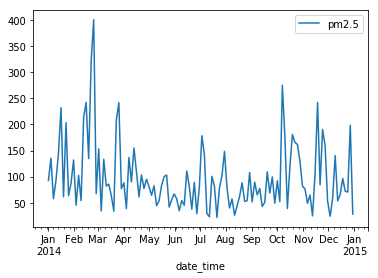

In [145]:
clean_data['2014'].resample('3D').mean().plot(y = 'pm2.5')
plt.show()

<p>Next, I split the data up into train and test sets. I use observations for 2014 as a test data. The target variable <i>y</i> is a column <b>pm2.5</b>. To predict its value, each model will use the past value of <b>pm2.5</b>. Those past values are stored in valiable <i>x</i>. Constant <i>lookback</i> defines how many past observations are available for the model to make a prediction. It is defined in the number of days, and each day consists of 24 observations.</p>

In [42]:
def train_test_split(lookback, clean_data):
    """Splin the input data on train and test subsets.
    """
    y_train = clean_data[:'2013']['pm2.5']
    y_test = clean_data['2014']['pm2.5']

    column_names = ['lag_1']
    x_train = y_train.shift()
    x_test = y_test.shift()
    for i in range(2, 24 * lookback + 1):
        x_train = pd.concat([x_train, y_train.shift(i)], axis = 1)
        x_test = pd.concat([x_test, y_test.shift(i)], axis = 1)
        column_names.append('lag_' + str(i))
    x_train = x_train[24 * lookback:]
    x_test = x_test[24 * lookback:]
    y_train = y_train[24 * lookback:]
    y_test = y_test[24 * lookback:]
    x_train.columns = column_names
    x_test.columns = column_names
    return [x_train, y_train, x_test, y_test]
    
def scale_train_test(x_train, x_test):
    """Normalize train and test subsets
    """
    scaler = StandardScaler()
    scaler.fit(x_train)
    x_train = scaler.transform(x_train)
    x_test = scaler.transform(x_test)
    return [x_train, x_test]

In [22]:
x_train, y_train, x_test, y_test = train_test_split(1, clean_data)

<p>Next, I define functions to compute Mean Square Error and Mean Absolute Error according to a baseline approach. Additionally, I plot the baseline predictions. I plot forecasts for several days in 2012 and 2014. The predicted values are plotted in orange and the true observations are plotted in blue.</p>

In [43]:
def base_line_mae(x, y):
    """Return mae for naive method to predict the outcome.
    Use value from the previouse day.
    """
    prediction = x['lag_1']
    return(np.mean(np.absolute(prediction - y)))

def base_line_mse(x, y):
    """Return mse for naive method to predict the outcome.
    Use value from the previouse day.
    """
    prediction = x['lag_1']
    return(np.mean(np.square(prediction - y)))

def plot_forecast(model, x_train, y_train, x_test, y_test):
    """Plot the model's forecast on the train and test datasets
    """
    if model == 'base':
        train_predict = pd.DataFrame(x_train['lag_1'])
        test_predict = pd.DataFrame(x_test['lag_1'])
    else:
        train_predict = pd.DataFrame(model.predict(x_train))
        test_predict = pd.DataFrame(model.predict(x_test))

    train_predict.columns = ['prediction']
    train_predict['date_time'] = y_train.index.values
    train_predict.set_index('date_time', inplace = True)
    train_plot = pd.concat([y_train, train_predict], axis = 1)

    test_predict.columns = ['prediction']
    test_predict['date_time'] = y_test.index.values
    test_predict.set_index('date_time', inplace = True)
    test_plot = pd.concat([y_test, test_predict], axis = 1)

    fig, axs = plt.subplots(2, 2, figsize = (15, 10))
    train_plot['Sep-05-2012':'Sep-08-2012'].plot(ax = axs[0, 0])
    test_plot['Sep-05-2014':'Sep-08-2014'].plot(ax = axs[0, 1])
    train_plot['Sep-01-2013'].plot(ax = axs[1, 0])
    test_plot['Sep-01-2014'].plot(ax = axs[1, 1])
    axs[0, 0].title.set_text('Train dataset')
    axs[0, 1].title.set_text('Test dataset')
    plt.show()

Mean absolute error of a naive predictor 13.236967827769714
Mean squared error of a naive predictor 630.882408079342


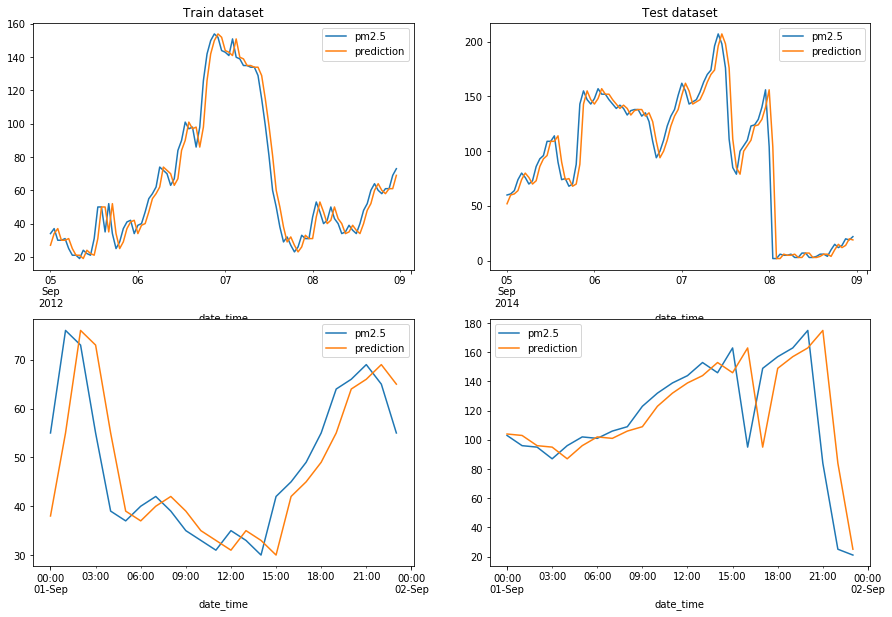

In [225]:
base_mae = base_line_mae(x_train, y_train)
base_mse = base_line_mse(x_train, y_train)
print("Mean absolute error of a naive predictor", base_mae)
print("Mean squared error of a naive predictor", base_mse)

plot_forecast('base', x_train, y_train, x_test, y_test)

<h3 style="text-align:center">Fully Connected ANN</h3>

<p>In this section, I build Fully Connected ANNs. First, I compare two loss functions: Mean Absolute Error and Mean Square Error. I begin by training the networks on time series consisting of one-day observations. So, as an input, the networks receive 24 air pollution measurements.</p>

In [44]:
def plot_loss(history):
    """Plot the learning curve
    """
    plt.plot(range(1, len(history.history['loss']) + 1), history.history['loss'])
    plt.plot(range(1, len(history.history['val_loss']) + 1), history.history['val_loss'])
    plt.title('Model Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['train', 'val'], loc = 'best')
    plt.show()

In [152]:
# Scale the input data
x_train, x_test = scale_train_test(x_train, x_test)

# Observations for 1 day only
lookback = 1 

# Build the model
ann_1 = Sequential()
ann_1.add(Dense(32, activation = 'relu', input_dim = 24 * lookback))
ann_1.add(Dense(16, activation = 'relu'))
ann_1.add(Dense(1))
ann_1.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_32 (Dense)             (None, 32)                800       
_________________________________________________________________
dense_33 (Dense)             (None, 16)                528       
_________________________________________________________________
dense_34 (Dense)             (None, 1)                 17        
Total params: 1,345
Trainable params: 1,345
Non-trainable params: 0
_________________________________________________________________


In [153]:
ann_1.compile(optimizer = 'rmsprop', loss = 'mean_absolute_error')
history_ann_1 = ann_1.fit(x_train, y_train, epochs = 100, batch_size = 256, verbose = 1, validation_split = 0.1)

Train on 29764 samples, validate on 3308 samples
Epoch 1/100
29764/29764 [==============================] - 5s 158us/step - loss: 93.6226 - val_loss: 79.1977
Epoch 2/100
29764/29764 [==============================] - 1s 32us/step - loss: 77.6720 - val_loss: 63.8909
Epoch 3/100
29764/29764 [==============================] - 1s 32us/step - loss: 59.8191 - val_loss: 50.2583
Epoch 4/100
29764/29764 [==============================] - 1s 35us/step - loss: 48.2586 - val_loss: 40.7572
Epoch 5/100
29764/29764 [==============================] - 1s 30us/step - loss: 38.8786 - val_loss: 33.6442
Epoch 6/100
29764/29764 [==============================] - 1s 34us/step - loss: 31.4965 - val_loss: 26.5854
Epoch 7/100
29764/29764 [==============================] - 1s 28us/step - loss: 24.7280 - val_loss: 21.1786
Epoch 8/100
29764/29764 [==============================] - 1s 36us/step - loss: 19.9759 - val_loss: 17.6736
Epoch 9/100
29764/29764 [==============================] - 1s 34us/step - loss: 17.342

KeyboardInterrupt: 

<p>The above output shows that the loss gradually decreases both on the training set and validation set. However, the loss function quickly reaches a plateau and never decreases after 20 epochs of training. So, at this point, I assume that this ANN reached its best accuracy. The lowest value of the loss function on the validation set is 12.2514 which is a bit lower than the baseline MAE = 13.2</p>

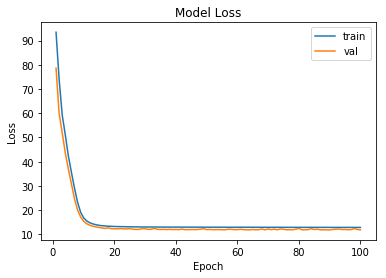

In [19]:
plot_loss(history_ann_1)

<p>Below I plot the values which the model forecasted. To make one prediction the model gets an input of 24 observations for one day.</p>

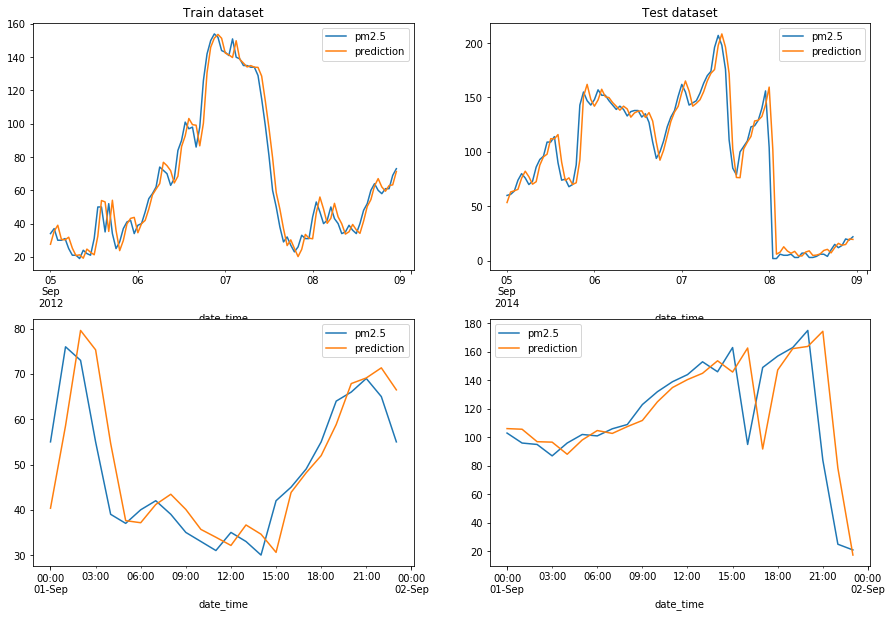

In [154]:
plot_forecast(ann_1, x_train, y_train, x_test, y_test)

<p>The above plotts are very similar to the baseline plots. So, fully connected ANN simply predicts a value of the previous observation.</p>

<p>Next, I check if the model improves if it minimizes MSE instead of MAE.</p>

In [24]:
ann_1.compile(optimizer = 'rmsprop', loss = 'mean_squared_error')
history_ann_1 = ann_1.fit(x_train, y_train, epochs = 100, batch_size = 256, verbose = 1, validation_split = 0.1)

Train on 29764 samples, validate on 3308 samples
Epoch 1/100
29764/29764 [==============================] - 1s 42us/step - loss: 15797.6953 - val_loss: 11139.9772
Epoch 2/100
29764/29764 [==============================] - 1s 22us/step - loss: 8807.3813 - val_loss: 6146.6690
Epoch 3/100
29764/29764 [==============================] - 1s 22us/step - loss: 5618.9346 - val_loss: 4190.6047
Epoch 4/100
29764/29764 [==============================] - 1s 22us/step - loss: 3823.1667 - val_loss: 2723.6068
Epoch 5/100
29764/29764 [==============================] - 1s 23us/step - loss: 2584.5634 - val_loss: 1861.0903
Epoch 6/100
29764/29764 [==============================] - 1s 24us/step - loss: 1810.3503 - val_loss: 1238.7121
Epoch 7/100
29764/29764 [==============================] - 1s 24us/step - loss: 1268.5421 - val_loss: 851.6523
Epoch 8/100
29764/29764 [==============================] - 1s 22us/step - loss: 983.7733 - val_loss: 684.5218
Epoch 9/100
29764/29764 [==============================]

<p>As in the previous case, MSE decreased significantly at the beginning of training and after that stayed almost the same. When I stopped training the loss was 572 which is better than the baseline. So, models trained with MSE and MAE performed almost the same. So, as there is not much difference, we pick MSE for our future models.</p>

<p>Next, I try different optimization algorithm.</p>

In [25]:
ann_1.compile(optimizer = 'adam', loss = 'mean_absolute_error')
history_ann_1 = ann_1.fit(x_train, y_train, epochs = 100, batch_size = 256, verbose = 1, validation_split = 0.1)

Train on 29764 samples, validate on 3308 samples
Epoch 1/100
29764/29764 [==============================] - 2s 54us/step - loss: 12.9073 - val_loss: 11.8043
Epoch 2/100
29764/29764 [==============================] - 1s 28us/step - loss: 12.8683 - val_loss: 11.8378
Epoch 3/100
29764/29764 [==============================] - 1s 21us/step - loss: 12.8507 - val_loss: 11.8162
Epoch 4/100
29764/29764 [==============================] - 1s 21us/step - loss: 12.8625 - val_loss: 11.8219
Epoch 5/100
29764/29764 [==============================] - 0s 16us/step - loss: 12.8457 - val_loss: 11.8050
Epoch 6/100
29764/29764 [==============================] - 1s 29us/step - loss: 12.8378 - val_loss: 11.8349
Epoch 7/100
29764/29764 [==============================] - 1s 18us/step - loss: 12.8416 - val_loss: 11.7873
Epoch 8/100
29764/29764 [==============================] - 1s 31us/step - loss: 12.8389 - val_loss: 11.8157
Epoch 9/100
29764/29764 [==============================] - 1s 25us/step - loss: 12.8469

In [606]:
train_score = ann_1.evaluate(x_train, y_train, verbose=0)
print('Train Score: %.2f MAE' % (train_score))
test_score = ann_1.evaluate(x_test, y_test, verbose=0)
print('Test Score: %.2f MAE' % (test_score))

Train Score: 12.57 MAE
Test Score: 11.41 MAE


<p>Both algorithms performed almost the same. So, I pick Adam for the future models.</p>
<p>Next, I train complex ANN using MSE and Adam. I use weak regularisation because on this dataset stronger regularisation impedes the learning process.</p>

In [64]:
lookback = 7 
x_train, y_train, x_test, y_test = train_test_split(lookback, clean_data)
x_train, x_test = scale_train_test(x_train, x_test)

In [65]:
ann_d = Sequential()
ann_d.add(Dense(15, activation = 'relu', input_dim = 24 * lookback))
ann_d.add(Dropout(0.05))
ann_d.add(Dense(15, activation = 'relu'))
ann_d.add(Dense(1))
ann_d.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_33 (Dense)             (None, 15)                2535      
_________________________________________________________________
dropout_4 (Dropout)          (None, 15)                0         
_________________________________________________________________
dense_34 (Dense)             (None, 15)                240       
_________________________________________________________________
dense_35 (Dense)             (None, 1)                 16        
Total params: 2,791
Trainable params: 2,791
Non-trainable params: 0
_________________________________________________________________


In [70]:
ann_d.compile(optimizer = 'adam', loss = 'mean_squared_error')
#the model was trained during 1500 epochs in total
history_ann_d = ann_d.fit(x_train, y_train, epochs = 10, batch_size = 256, verbose = 1, validation_split = 0.1)

Train on 29635 samples, validate on 3293 samples
Epoch 1/10
29635/29635 [==============================] - 4s 119us/step - loss: 507.2732 - val_loss: 479.9663
Epoch 2/10
29635/29635 [==============================] - 1s 46us/step - loss: 501.2087 - val_loss: 462.7775
Epoch 3/10
29635/29635 [==============================] - 1s 46us/step - loss: 503.3340 - val_loss: 472.8135
Epoch 4/10
29635/29635 [==============================] - 1s 45us/step - loss: 500.4678 - val_loss: 473.5128
Epoch 5/10
29635/29635 [==============================] - 1s 46us/step - loss: 504.3952 - val_loss: 465.0431
Epoch 6/10
29635/29635 [==============================] - 1s 42us/step - loss: 502.6057 - val_loss: 464.4769
Epoch 7/10
29635/29635 [==============================] - 1s 46us/step - loss: 500.4046 - val_loss: 472.1176
Epoch 8/10
29635/29635 [==============================] - 1s 43us/step - loss: 506.3567 - val_loss: 470.1290
Epoch 9/10
29635/29635 [==============================] - 1s 41us/step - loss:

In [73]:
ann_d.load_weights("models/ann_d")

Train Score: 496.37 MSE (22.28 RMSE)
Test Score: 522.69 MSE (22.86 RMSE)


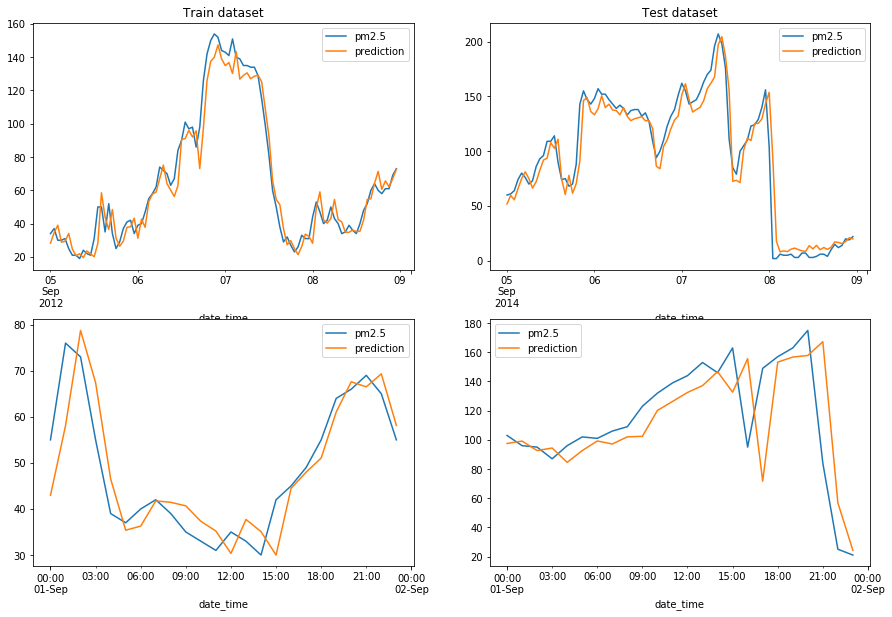

In [74]:
train_score = ann_d.evaluate(x_train, y_train, verbose=0)
print('Train Score: %.2f MSE (%.2f RMSE)' % (train_score, math.sqrt(train_score)))
test_score = ann_d.evaluate(x_test, y_test, verbose=0)
print('Test Score: %.2f MSE (%.2f RMSE)' % (test_score, math.sqrt(test_score)))

plot_forecast(ann_d, x_train, y_train, x_test, y_test)

<p>The above model produces good results and outperformaed baseline model with a significant margin</p>
<p>Next, I build RNNs and check if those networks can better capture the time series data.</p>

<h3 style="text-align:center">RNN Models</h3>

<p>I begin by creating a simple RNN which gets as an input only one past observation.</p>

In [155]:
x_train = x_train[:, 0:1].reshape(x_train.shape[0], 1, 1)
x_test = x_test[:, 0:1].reshape(x_test.shape[0], 1, 1)

rnn_1 = Sequential()
rnn_1.add(SimpleRNN(9, input_shape = (1, 1)))
rnn_1.add(Dense(1))
rnn_1.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
simple_rnn_7 (SimpleRNN)     (None, 9)                 99        
_________________________________________________________________
dense_35 (Dense)             (None, 1)                 10        
Total params: 109
Trainable params: 109
Non-trainable params: 0
_________________________________________________________________


In [37]:
rnn_1.compile(loss = 'mean_squared_error', optimizer = 'adam')
history_rnn_1 = rnn_1.fit(x_train, y_train, epochs = 500, batch_size = 256, verbose = 1)

Epoch 1/500
33024/33024 [==============================] - 2s 55us/step - loss: 829.0917
Epoch 2/500
33024/33024 [==============================] - 1s 20us/step - loss: 826.2752
Epoch 3/500
33024/33024 [==============================] - 1s 21us/step - loss: 823.5426
Epoch 4/500
33024/33024 [==============================] - 1s 31us/step - loss: 820.9592
Epoch 5/500
33024/33024 [==============================] - 1s 26us/step - loss: 818.3524
Epoch 6/500
33024/33024 [==============================] - 1s 25us/step - loss: 815.8018
Epoch 7/500
33024/33024 [==============================] - 1s 27us/step - loss: 813.4111
Epoch 8/500
33024/33024 [==============================] - 1s 22us/step - loss: 811.0209
Epoch 9/500
33024/33024 [==============================] - 1s 23us/step - loss: 808.6706
Epoch 10/500
33024/33024 [==============================] - 1s 25us/step - loss: 806.3694
Epoch 11/500
33024/33024 [==============================] - 1s 24us/step - loss: 804.1340
Epoch 12/500
33024/

Epoch 181/500
33024/33024 [==============================] - 1s 23us/step - loss: 672.4112
Epoch 182/500
33024/33024 [==============================] - 1s 23us/step - loss: 672.2091
Epoch 183/500
33024/33024 [==============================] - 1s 20us/step - loss: 672.0745
Epoch 184/500
33024/33024 [==============================] - 1s 24us/step - loss: 671.7622
Epoch 185/500
33024/33024 [==============================] - 1s 23us/step - loss: 671.4642
Epoch 186/500
33024/33024 [==============================] - 1s 22us/step - loss: 671.3465
Epoch 187/500
33024/33024 [==============================] - 1s 22us/step - loss: 671.0114
Epoch 188/500
33024/33024 [==============================] - 1s 24us/step - loss: 670.9543
Epoch 189/500
33024/33024 [==============================] - 1s 21us/step - loss: 670.6457
Epoch 190/500
33024/33024 [==============================] - 1s 22us/step - loss: 670.5050
Epoch 191/500
33024/33024 [==============================] - 1s 23us/step - loss: 670.3583

33024/33024 [==============================] - 1s 26us/step - loss: 658.3041
Epoch 272/500
33024/33024 [==============================] - 1s 22us/step - loss: 658.1890
Epoch 273/500
33024/33024 [==============================] - 1s 23us/step - loss: 657.9948
Epoch 274/500
33024/33024 [==============================] - 1s 22us/step - loss: 657.8987
Epoch 275/500
33024/33024 [==============================] - 1s 22us/step - loss: 657.6919
Epoch 276/500
33024/33024 [==============================] - 1s 24us/step - loss: 657.6396
Epoch 277/500
33024/33024 [==============================] - 1s 25us/step - loss: 657.5755
Epoch 278/500
33024/33024 [==============================] - 1s 21us/step - loss: 657.4896
Epoch 279/500
33024/33024 [==============================] - 1s 23us/step - loss: 657.3648
Epoch 280/500
33024/33024 [==============================] - 1s 24us/step - loss: 657.2276
Epoch 281/500
33024/33024 [==============================] - 1s 24us/step - loss: 657.1225
Epoch 282/500

33024/33024 [==============================] - 1s 25us/step - loss: 650.6681
Epoch 362/500
33024/33024 [==============================] - 1s 23us/step - loss: 650.6329
Epoch 363/500
33024/33024 [==============================] - 1s 27us/step - loss: 650.5122
Epoch 364/500
33024/33024 [==============================] - 1s 23us/step - loss: 650.4882
Epoch 365/500
33024/33024 [==============================] - 1s 22us/step - loss: 650.3630
Epoch 366/500
33024/33024 [==============================] - 1s 23us/step - loss: 650.2888
Epoch 367/500
33024/33024 [==============================] - 1s 21us/step - loss: 650.2591
Epoch 368/500
33024/33024 [==============================] - 1s 20us/step - loss: 650.3063
Epoch 369/500
33024/33024 [==============================] - 1s 25us/step - loss: 650.1667
Epoch 370/500
33024/33024 [==============================] - 1s 21us/step - loss: 650.0491
Epoch 371/500
33024/33024 [==============================] - 1s 22us/step - loss: 650.1234
Epoch 372/500

In [156]:
rnn_1.load_weights("models/rnn_1")

Train Score: 642.89 MSE (25.36 RMSE)
Test Score: 494.68 MSE (22.24 RMSE)


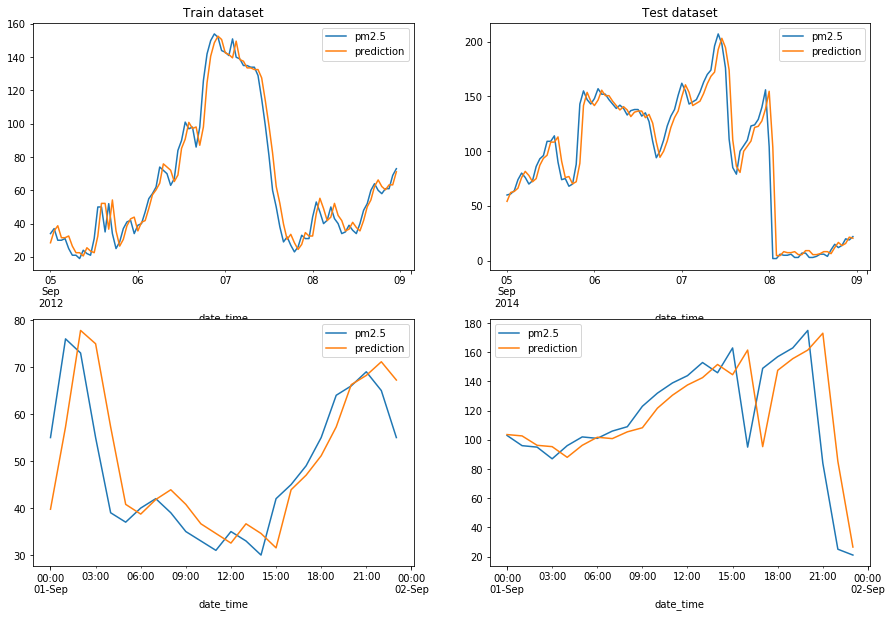

In [54]:
train_score = rnn_1.evaluate(x_train, y_train, verbose=0)
print('Train Score: %.2f MSE (%.2f RMSE)' % (train_score, math.sqrt(train_score)))
test_score = rnn_1.evaluate(x_test, y_test, verbose=0)
print('Test Score: %.2f MSE (%.2f RMSE)' % (test_score, math.sqrt(test_score)))

plot_forecast(rnn_1, x_train, y_train, x_test, y_test)

<p>Plots above show that a simple RNN echoes its input. It is expected because the model gets only one past value.</p>

<p>Next, I try to train RNN on one-day observations. So, as an input, the networks receive 24 air pollution measurements.</p>

In [157]:
lookback = 1
x_train, y_train, x_test, y_test = train_test_split(lookback, clean_data)
x_train, x_test = scale_train_test(x_train, x_test)
x_train = x_train.reshape(x_train.shape[0], x_train.shape[1], 1)
x_test = x_test.reshape(x_test.shape[0], x_test.shape[1], 1)

In [158]:
rnn_24 = Sequential()
rnn_24.add(SimpleRNN(9, input_shape = (lookback*24, 1)))
rnn_24.add(Dense(1))
rnn_24.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
simple_rnn_8 (SimpleRNN)     (None, 9)                 99        
_________________________________________________________________
dense_36 (Dense)             (None, 1)                 10        
Total params: 109
Trainable params: 109
Non-trainable params: 0
_________________________________________________________________


In [45]:
rnn_24.compile(loss = 'mean_squared_error', optimizer = 'adam')
#the model was trained during 1700 epochs in total
rnn_24.fit(x_train, y_train, epochs = 170, batch_size = 256, verbose = 1)

Epoch 1/170
33072/33072 [==============================] - 3s 101us/step - loss: 15752.7604
Epoch 2/170
33072/33072 [==============================] - 2s 63us/step - loss: 15528.3127
Epoch 3/170
33072/33072 [==============================] - 2s 60us/step - loss: 15312.5987
Epoch 4/170
33072/33072 [==============================] - 2s 64us/step - loss: 15102.3824
Epoch 5/170
33072/33072 [==============================] - 2s 59us/step - loss: 14897.4028
Epoch 6/170
33072/33072 [==============================] - 2s 67us/step - loss: 14696.6632
Epoch 7/170
33072/33072 [==============================] - 2s 63us/step - loss: 14500.5145
Epoch 8/170
33072/33072 [==============================] - 2s 66us/step - loss: 14308.2090
Epoch 9/170
33072/33072 [==============================] - 2s 66us/step - loss: 14120.5036
Epoch 10/170
33072/33072 [==============================] - 2s 60us/step - loss: 13937.2995
Epoch 11/170
33072/33072 [==============================] - 2s 63us/step - loss: 13758.0

In [58]:
rnn_24.load_weights("models/rnn_24.h5")

<p>I stopped training the above RNN after the loss function did not significantly decrease after 400 epochs.</p>

Train Score: 655.89 MSE (25.61 RMSE)
Test Score: 481.33 MSE (21.94 RMSE)


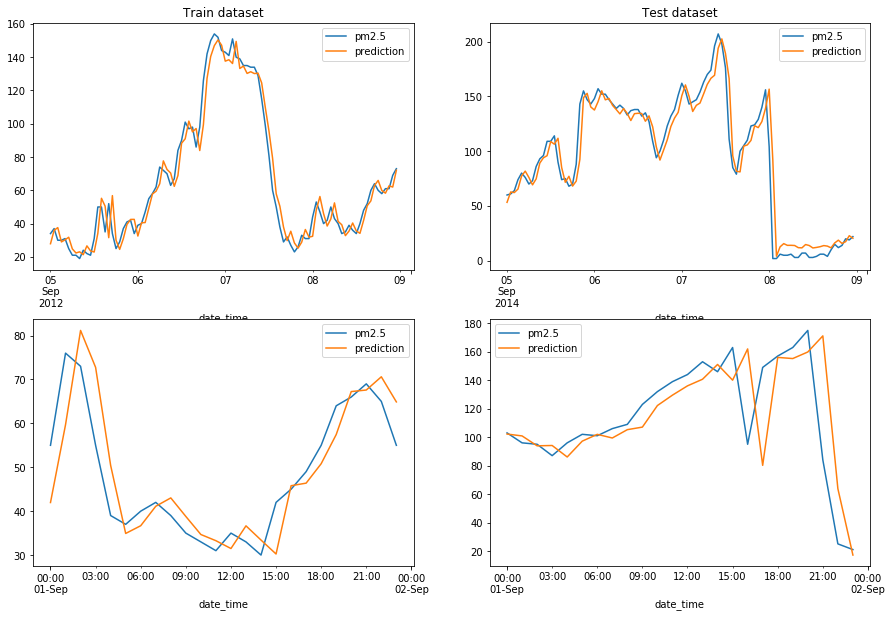

In [59]:
train_score = rnn_24.evaluate(x_train, y_train, verbose=0)
print('Train Score: %.2f MSE (%.2f RMSE)' % (train_score, math.sqrt(train_score)))
test_score = rnn_24.evaluate(x_test, y_test, verbose=0)
print('Test Score: %.2f MSE (%.2f RMSE)' % (test_score, math.sqrt(test_score)))

plot_forecast(rnn_24, x_train, y_train, x_test, y_test)

<p>RNN trained on one-day observations does not perform very well. I assume that one-day time series is too short to learn any patterns from the data. So, RNN learns that the best strategy is to echo its input.</p>

<p>So, we try to train an RNN on 3-day and 7-day time series.</p>

In [60]:
lookback = 3
x_train, y_train, x_test, y_test = train_test_split(lookback, clean_data)
x_train, x_test = scale_train_test(x_train, x_test)
x_train = x_train.reshape(x_train.shape[0], x_train.shape[1], 1)
x_test = x_test.reshape(x_test.shape[0], x_test.shape[1], 1)

In [61]:
rnn_72 = Sequential()
rnn_72.add(SimpleRNN(9, input_shape = (lookback * 24, 1)))
rnn_72.add(Dense(1))
rnn_72.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
simple_rnn_4 (SimpleRNN)     (None, 9)                 99        
_________________________________________________________________
dense_19 (Dense)             (None, 1)                 10        
Total params: 109
Trainable params: 109
Non-trainable params: 0
_________________________________________________________________


In [62]:
rnn_72.compile(loss = 'mean_squared_error', optimizer = 'adam')
#the model was trained during 1300 epochs in total
history_rnn_72 = rnn_72.fit(x_train, y_train, epochs = 50, verbose = 1, batch_size = 256, validation_split = 0.1)

Train on 29721 samples, validate on 3303 samples
Epoch 1/50
29721/29721 [==============================] - 6s 212us/step - loss: 18349.0011 - val_loss: 16044.0003
Epoch 2/50
29721/29721 [==============================] - 4s 145us/step - loss: 17879.2574 - val_loss: 15395.2959
Epoch 3/50
29721/29721 [==============================] - 5s 166us/step - loss: 17286.2424 - val_loss: 14954.5209
Epoch 4/50
29721/29721 [==============================] - 4s 145us/step - loss: 16876.0450 - val_loss: 14657.7656
Epoch 5/50
29721/29721 [==============================] - 4s 141us/step - loss: 16585.7992 - val_loss: 14417.2973
Epoch 6/50
29721/29721 [==============================] - 4s 144us/step - loss: 16335.5396 - val_loss: 14199.4605
Epoch 7/50
29721/29721 [==============================] - 4s 144us/step - loss: 16104.4807 - val_loss: 13994.6120
Epoch 8/50
29721/29721 [==============================] - 4s 146us/step - loss: 15885.6119 - val_loss: 13799.0898
Epoch 9/50
29721/29721 [===============

<p>I stopped training the above RNN after the loss function did not significantly decrease after 400 epochs.</p>

In [63]:
rnn_72.load_weights("models/rnn_72.h5")

Train Score: 666.54 MSE (25.82 RMSE)
Test Score: 530.11 MSE (23.02 RMSE)


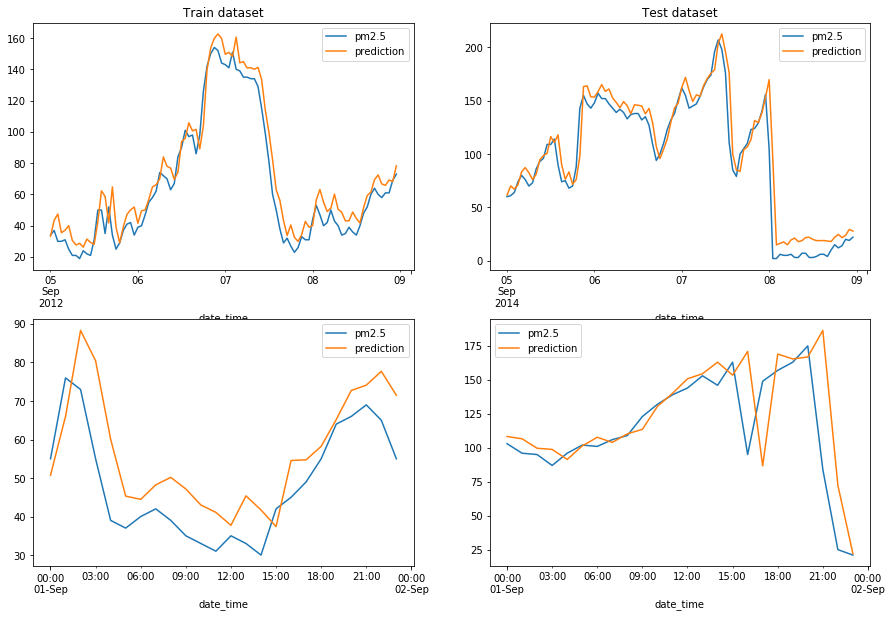

In [64]:
train_score = rnn_72.evaluate(x_train, y_train, verbose=0)
print('Train Score: %.2f MSE (%.2f RMSE)' % (train_score, math.sqrt(train_score)))
test_score = rnn_72.evaluate(x_test, y_test, verbose=0)
print('Test Score: %.2f MSE (%.2f RMSE)' % (test_score, math.sqrt(test_score)))

plot_forecast(rnn_72, x_train, y_train, x_test, y_test)

<p>Comparing with the previous model, I would say that this one captures more patterns in the input data, and it less echoes its input. However, it is far from a desirable model.</p>

In [54]:
lookback = 7
x_train, y_train, x_test, y_test = train_test_split(lookback, clean_data)
x_train, x_test = scale_train_test(x_train, x_test)
x_train = x_train.reshape(x_train.shape[0], x_train.shape[1], 1)
x_test = x_test.reshape(x_test.shape[0], x_test.shape[1], 1)

In [55]:
rnn_168 = Sequential()
rnn_168.add(SimpleRNN(36, input_shape = (lookback * 24, 1)))
rnn_168.add(Dense(1))
rnn_168.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
simple_rnn_1 (SimpleRNN)     (None, 36)                1368      
_________________________________________________________________
dense_32 (Dense)             (None, 1)                 37        
Total params: 1,405
Trainable params: 1,405
Non-trainable params: 0
_________________________________________________________________


In [56]:
rnn_168.compile(loss = 'mean_squared_error', optimizer = 'adam')
#the model was trained during 200 epochs in total
history_rnn_168 = rnn_168.fit(x_train, y_train, epochs = 5, verbose = 1, batch_size = 256, validation_split = 0.1)

Train on 29635 samples, validate on 3293 samples
Epoch 1/5
29635/29635 [==============================] - 16s 554us/step - loss: 17457.1763 - val_loss: 14609.1886
Epoch 2/5
29635/29635 [==============================] - 14s 475us/step - loss: 16199.3004 - val_loss: 13810.5489
Epoch 3/5
29635/29635 [==============================] - 14s 471us/step - loss: 15397.7220 - val_loss: 13134.8422
Epoch 4/5
29635/29635 [==============================] - 14s 476us/step - loss: 14696.9932 - val_loss: 12534.2153
Epoch 5/5
29635/29635 [==============================] - 14s 489us/step - loss: 14064.3249 - val_loss: 11990.5561


In [74]:
rnn_168.load_weights("models/rnn_168.h5")

Train Score: 8415.65 MSE (91.74 RMSE)
Test Score: 8794.91 MSE (93.78 RMSE)


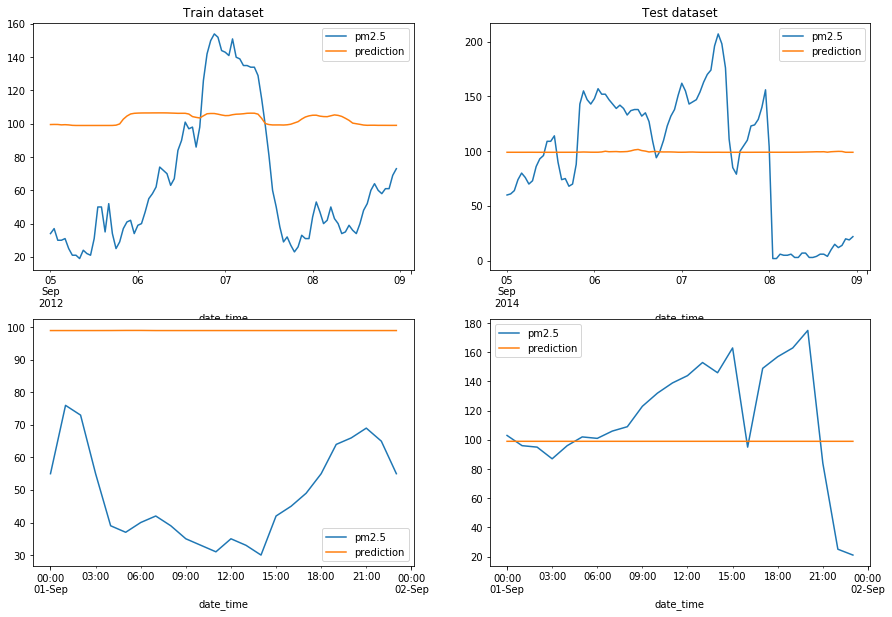

In [75]:
train_score = rnn_168.evaluate(x_train, y_train, verbose=0)
print('Train Score: %.2f MSE (%.2f RMSE)' % (train_score, math.sqrt(train_score)))
test_score = rnn_168.evaluate(x_test, y_test, verbose=0)
print('Test Score: %.2f MSE (%.2f RMSE)' % (test_score, math.sqrt(test_score)))

plot_forecast(rnn_168, x_train, y_train, x_test, y_test)

<p>The plot above shows that after 200 epochs the last model did not improve much. Complex RNNs are notorious for being difficult to train.</p>

<p>So, a simple RNN model is not better then a complex fully connected ANN. Additionally, more complex RNN required a lot of time to train. Next, I check if LSTM can improve training and accuracy of forecasting.</p>

<h3 style="text-align:center">LSTM Models</h3>

<p>LSTM models are considered to be better than RNN in capturing time series data. So, I do not train any model on 1-day observations and begin by training my first LSTM model on 3-day time series.</p>

In [79]:
lookback = 3
x_train, y_train, x_test, y_test = train_test_split(lookback, clean_data)
x_train, x_test = scale_train_test(x_train, x_test)
x_train = x_train.reshape(x_train.shape[0], x_train.shape[1], 1)
x_test = x_test.reshape(x_test.shape[0], x_test.shape[1], 1)

In [80]:
lstm_72 = Sequential()
lstm_72.add(LSTM(24, input_shape = (lookback * 24, 1)))
lstm_72.add(Dense(1))
lstm_72.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 24)                2496      
_________________________________________________________________
dense_22 (Dense)             (None, 1)                 25        
Total params: 2,521
Trainable params: 2,521
Non-trainable params: 0
_________________________________________________________________


In [83]:
lstm_72.compile(loss = 'mean_squared_error', optimizer = 'adam')
#the model was trained during 1200 epochs in total
history_lstm_72 = lstm_72.fit(x_train, y_train, epochs = 5, verbose = 1, batch_size = 256, validation_split = 0.1)

Train on 29721 samples, validate on 3303 samples
Epoch 1/5
29721/29721 [==============================] - 28s 946us/step - loss: 17301.4320 - val_loss: 14685.6639
Epoch 2/5
29721/29721 [==============================] - 24s 793us/step - loss: 16455.0100 - val_loss: 14157.9004
Epoch 3/5
29721/29721 [==============================] - 23s 759us/step - loss: 15911.9905 - val_loss: 13684.6053
Epoch 4/5
29721/29721 [==============================] - 22s 755us/step - loss: 15412.7652 - val_loss: 13245.9194
Epoch 5/5
29721/29721 [==============================] - 22s 742us/step - loss: 14945.7334 - val_loss: 12835.2387


In [84]:
lstm_72.load_weights("models/lstm_72.h5")

Train Score: 508.09 MSE (22.54 RMSE)
Test Score: 465.07 MSE (21.57 RMSE)


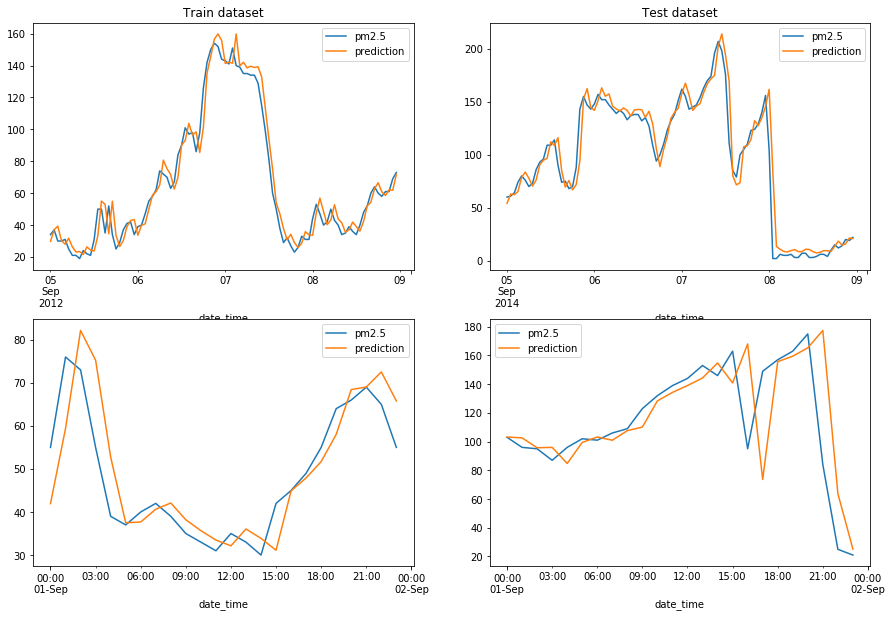

In [85]:
train_score = lstm_72.evaluate(x_train, y_train, verbose=0)
print('Train Score: %.2f MSE (%.2f RMSE)' % (train_score, math.sqrt(train_score)))
test_score = lstm_72.evaluate(x_test, y_test, verbose=0)
print('Test Score: %.2f MSE (%.2f RMSE)' % (test_score, math.sqrt(test_score)))

plot_forecast(lstm_72, x_train, y_train, x_test, y_test)

<p>This LSTM has MSE lower than the baseline and it performed better than the corresponding RNN.</p>
<p>Next, I try to train LSTM on 7-day sitme series.</p>

In [86]:
lookback = 7
x_train, y_train, x_test, y_test = train_test_split(lookback, clean_data)
x_train, x_test = scale_train_test(x_train, x_test)
x_train = x_train.reshape(x_train.shape[0], x_train.shape[1], 1)
x_test = x_test.reshape(x_test.shape[0], x_test.shape[1], 1)

In [87]:
lstm_168 = Sequential()
lstm_168.add(LSTM(48, input_shape = (lookback * 24, 1)))
lstm_168.add(Dense(1))
lstm_168.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_2 (LSTM)                (None, 48)                9600      
_________________________________________________________________
dense_23 (Dense)             (None, 1)                 49        
Total params: 9,649
Trainable params: 9,649
Non-trainable params: 0
_________________________________________________________________


In [90]:
lstm_168.compile(loss = 'mean_squared_error', optimizer = 'adam')
#the model was trained during 3000 epochs in total
lstm_168.fit(x_train, y_train, epochs = 2, batch_size = 256, verbose = 1, validation_split = 0.1)

Train on 29635 samples, validate on 3293 samples
Epoch 1/2
29635/29635 [==============================] - 90s 3ms/step - loss: 16422.5971 - val_loss: 13622.6008
Epoch 2/2
29635/29635 [==============================] - 86s 3ms/step - loss: 15092.3308 - val_loss: 12775.4965


In [94]:
lstm_168.load_weights("models/lstm_168.h5")

Train Score: 528.63 MSE (22.99 RMSE)
Test Score: 466.22 MSE (21.59 RMSE)


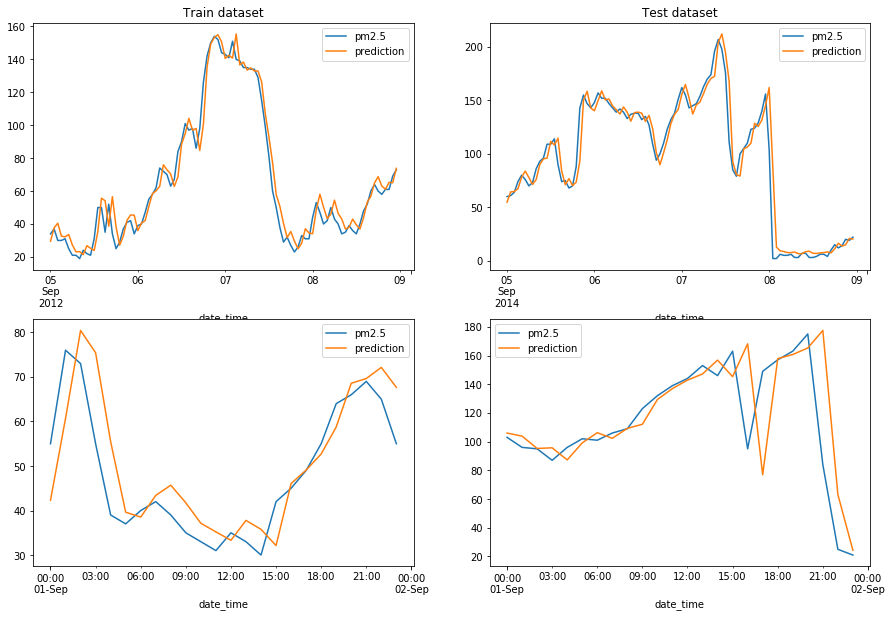

In [95]:
train_score = lstm_168.evaluate(x_train, y_train, verbose=0)
print('Train Score: %.2f MSE (%.2f RMSE)' % (train_score, math.sqrt(train_score)))
test_score = lstm_168.evaluate(x_test, y_test, verbose=0)
print('Test Score: %.2f MSE (%.2f RMSE)' % (test_score, math.sqrt(test_score)))

plot_forecast(lstm_168, x_train, y_train, x_test, y_test)

<p>I could train a good LSTM model on a very long time series. In comparison, the corresponding RNN did not converge at all. So, LSTM is a good improvement over RNN.</p>

<h3 style="text-align:center">Models with Attention Mechanism</h3>

<p>Next, I implement Attention Mechanism (module <i>attention.py</i>) and train networks on 3-day and 7-day time series.</p>

In [96]:
lookback = 3
x_train, y_train, x_test, y_test = train_test_split(lookback, clean_data)
x_train, x_test = scale_train_test(x_train, x_test)
x_train = x_train.reshape(x_train.shape[0], x_train.shape[1], 1)
x_test = x_test.reshape(x_test.shape[0], x_test.shape[1], 1)

In [97]:
attention_72 = Sequential()
attention_72.add(LSTM(24, input_shape = (lookback * 24, 1), return_sequences = True))
attention_72.add(Attention())
attention_72.add(Dense(1))
attention_72.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_3 (LSTM)                (None, 72, 24)            2496      
_________________________________________________________________
attention_1 (Attention)      (None, 24)                96        
_________________________________________________________________
dense_24 (Dense)             (None, 1)                 25        
Total params: 2,617
Trainable params: 2,617
Non-trainable params: 0
_________________________________________________________________


In [99]:
attention_72.compile(loss = 'mean_squared_error', optimizer = 'adam')
#the model was trained during 1500 epochs in total
attention_72.fit(x_train, y_train, epochs = 2, batch_size = 256, verbose = 1)

Epoch 1/2
33024/33024 [==============================] - 38s 1ms/step - loss: 15994.8043
Epoch 2/2
33024/33024 [==============================] - 32s 973us/step - loss: 15441.0827


In [100]:
attention_72.load_weights("models/attention_72")

Train Score: 448.92 MSE (21.19 RMSE)
Test Score: 484.34 MSE (22.01 RMSE)


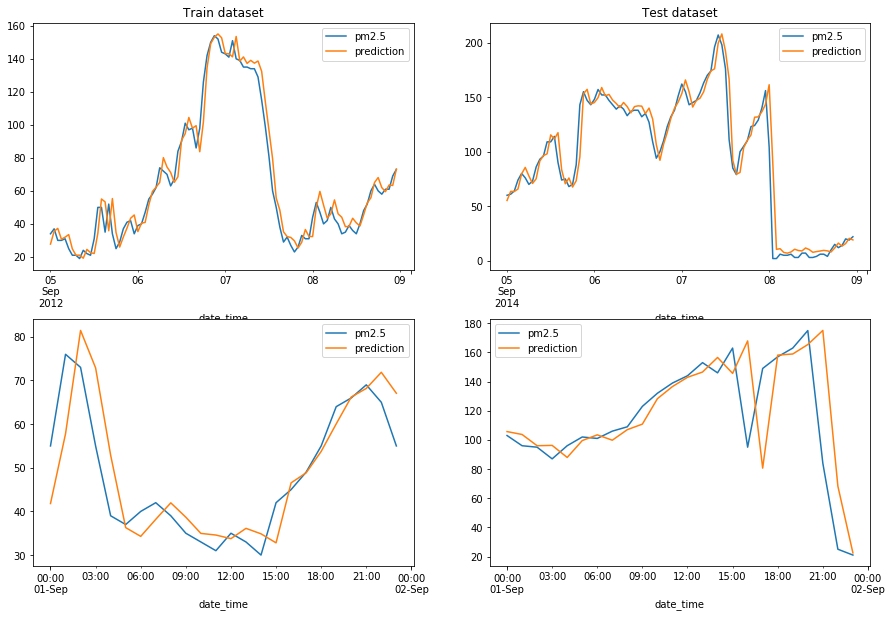

In [101]:
train_score = attention_72.evaluate(x_train, y_train, verbose=0)
print('Train Score: %.2f MSE (%.2f RMSE)' % (train_score, math.sqrt(train_score)))
test_score = attention_72.evaluate(x_test, y_test, verbose=0)
print('Test Score: %.2f MSE (%.2f RMSE)' % (test_score, math.sqrt(test_score)))

plot_forecast(attention_72, x_train, y_train, x_test, y_test)

<p>This models with Attention performed slightly better than pure LSTM model.</p>

In [102]:
lookback = 7
x_train, y_train, x_test, y_test = train_test_split(lookback, clean_data)
x_train, x_test = scale_train_test(x_train, x_test)
x_train = x_train.reshape(x_train.shape[0], x_train.shape[1], 1)
x_test = x_test.reshape(x_test.shape[0], x_test.shape[1], 1)

In [103]:
attention_168 = Sequential()
attention_168.add(LSTM(24, input_shape = (lookback * 24, 1), return_sequences = True))
attention_168.add(Attention())
attention_168.add(Dense(1))
attention_168.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_4 (LSTM)                (None, 168, 24)           2496      
_________________________________________________________________
attention_2 (Attention)      (None, 24)                192       
_________________________________________________________________
dense_25 (Dense)             (None, 1)                 25        
Total params: 2,713
Trainable params: 2,713
Non-trainable params: 0
_________________________________________________________________


In [104]:
attention_168.compile(loss = 'mean_squared_error', optimizer = 'adam')
#the model was trained during 2000 epochs in total
attention_168.fit(x_train, y_train, epochs = 2, batch_size = 256, verbose = 1)

Epoch 1/2
32928/32928 [==============================] - 91s 3ms/step - loss: 17412.1044
Epoch 2/2
32928/32928 [==============================] - 79s 2ms/step - loss: 16125.6227


In [109]:
attention_168.load_weights("models/attention_168.h5")

Train Score: 510.93 MSE (22.60 RMSE)
Test Score: 482.00 MSE (21.95 RMSE)


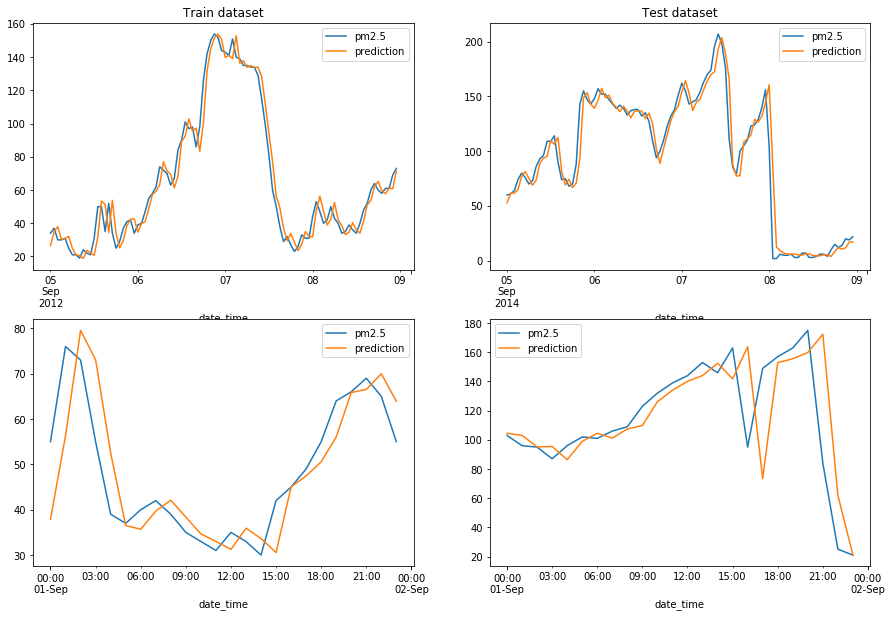

In [110]:
train_score = attention_168.evaluate(x_train, y_train, verbose=0)
print('Train Score: %.2f MSE (%.2f RMSE)' % (train_score, math.sqrt(train_score)))
test_score = attention_168.evaluate(x_test, y_test, verbose=0)
print('Test Score: %.2f MSE (%.2f RMSE)' % (test_score, math.sqrt(test_score)))

plot_forecast(attention_168, x_train, y_train, x_test, y_test)

<p>Models with Attention have smaller MSE than the corresponding LSTM models. However, plots changed slightly. I would say that the model more accurately forecasts smooth changes. On the other hand, sharp rises or drops could be outliers in the dataset. For example, some measurements can be missing. So, there could be no pattern that the neural network can learn.</p>

<h4 style="text-align:center">China currency exchange rates dataset</h4>

<p>Finally, I train LSTM with Attention on China currency exchange rates. I use the same approach to compute the baseline predictions.</p>

In [111]:
def plot_forecast(model, rates_x_train, rates_y_train, rates_x_test, rates_y_test):
    """Plot the exchange rates model's forecast on the train and test datasets
    """
    if model == 'base':
        train_predict = pd.DataFrame(rates_x_train['lag_1'])
        test_predict = pd.DataFrame(rates_x_test['lag_1'])
    else:
        train_predict = pd.DataFrame(model.predict(rates_x_train))
        test_predict = pd.DataFrame(model.predict(rates_x_test))

    train_predict.columns = ['prediction']
    train_predict['date_time'] = rates_y_train.index.values
    train_predict.set_index('date_time', inplace = True)
    train_plot = pd.concat([rates_y_train, train_predict], axis = 1)

    test_predict.columns = ['prediction']
    test_predict['date_time'] = rates_y_test.index.values
    test_predict.set_index('date_time', inplace = True)
    test_plot = pd.concat([rates_y_test, test_predict], axis = 1)

    fig, axs = plt.subplots(1, 2, figsize = (15, 5))
    axs[0].plot(range(len(train_plot['Jan-2016':'Sep-2016'])), train_plot['Jan-2016':'Sep-2016'])
    axs[1].plot(range(len(test_plot['Jan-2017':'Sep-2017'])), test_plot['Jan-2017':'Sep-2017'])
    axs[0].title.set_text('Train dataset')
    axs[1].title.set_text('Test dataset')
    plt.show()

In [112]:
rates_input_data = pd.read_csv("input/usd_to_china.csv")
rates_clean_data = rates_input_data[rates_input_data['rate'] != 'ND']
rates_clean_data = rates_clean_data.assign(date_time = pd.to_datetime(rates_clean_data['data']))
rates_clean_data.set_index('date_time', inplace = True)
rates_clean_data = pd.DataFrame(rates_clean_data['rate'].astype(float))
rates_clean_data.columns = ['rate']
rates_clean_data.head()

,rate
date_time,
1981-01-02,1.5341
1981-01-05,1.5418
1981-01-06,1.5264
1981-01-07,1.5264
1981-01-08,1.5264


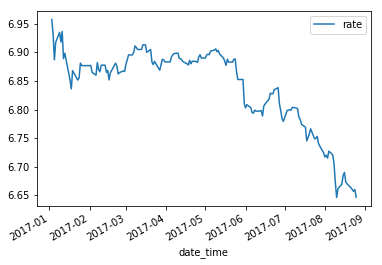

In [113]:
rates_clean_data['2017'].plot(y = 'rate')
plt.show()

In [115]:
lookback = 72
rates_y_train = rates_clean_data[:'2017']['rate']
rates_y_test = rates_clean_data['2017']['rate']
column_names = ['lag_1']
rates_x_train = rates_y_train.shift()
rates_x_test = rates_y_test.shift()
for i in range(2, lookback + 1):
    rates_x_train = pd.concat([rates_x_train, rates_y_train.shift(i)], axis = 1)
    rates_x_test = pd.concat([rates_x_test, rates_y_test.shift(i)], axis = 1)
    column_names.append('lag_' + str(i))
rates_x_train = rates_x_train[lookback:]
rates_x_test = rates_x_test[lookback:]
rates_y_train = rates_y_train[lookback:]
rates_y_test = rates_y_test[lookback:]
rates_x_train.columns = column_names
rates_x_test.columns = column_names

Mean squared error of a naive predictor 0.0011473151911424945


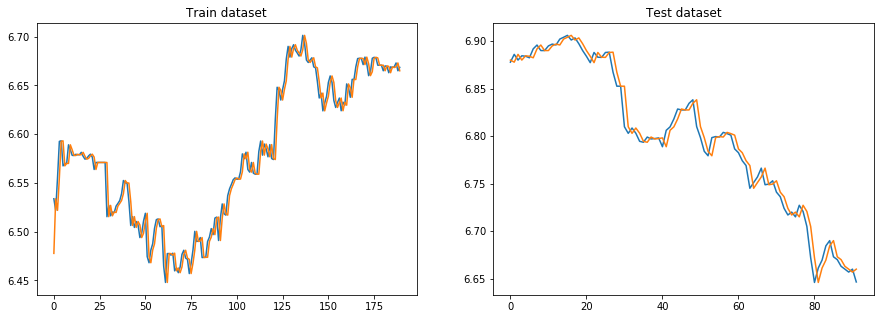

In [116]:
print("Mean squared error of a naive predictor", np.mean(np.square(rates_x_train['lag_1'] - rates_y_train)))
plot_forecast('base', rates_x_train, rates_y_train, rates_x_test, rates_y_test)

In [117]:
rates_x_train, rates_x_test = scale_train_test(rates_x_train, rates_x_test)
rates_x_train = rates_x_train.reshape(rates_x_train.shape[0], rates_x_train.shape[1], 1)
rates_x_test = rates_x_test.reshape(rates_x_test.shape[0], rates_x_test.shape[1], 1)

rates_72 = Sequential()
rates_72.add(LSTM(24, input_shape = (lookback, 1), return_sequences = True))
rates_72.add(Attention())
rates_72.add(Dense(1))
rates_72.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_5 (LSTM)                (None, 72, 24)            2496      
_________________________________________________________________
attention_3 (Attention)      (None, 24)                96        
_________________________________________________________________
dense_26 (Dense)             (None, 1)                 25        
Total params: 2,617
Trainable params: 2,617
Non-trainable params: 0
_________________________________________________________________


In [119]:
rates_72.compile(loss = 'mean_squared_error', optimizer = 'adam')
#the model was trained during 1000 epochs in total
rates_72.fit(rates_x_train, rates_y_train, epochs = 2, batch_size = 256, verbose = 1)

Epoch 1/2
9077/9077 [==============================] - 14s 2ms/step - loss: 35.5498
Epoch 2/2
9077/9077 [==============================] - 10s 1ms/step - loss: 12.9140


In [120]:
rates_72.load_weights("models/rates_72.h5")

Train Score: 0.0012 MSE (0.0350 RMSE)
Test Score: 0.0003 MSE (0.0159 RMSE)


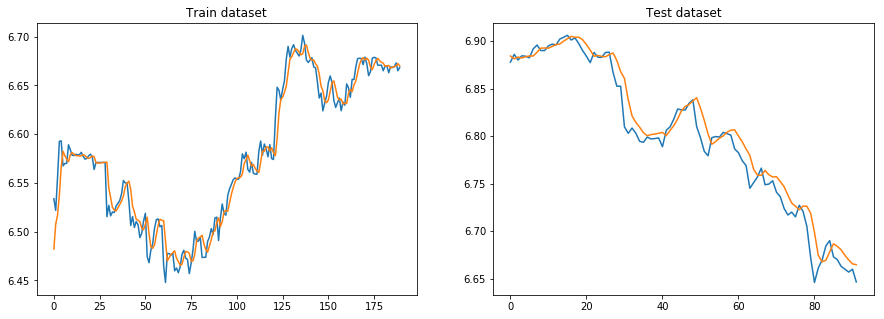

In [121]:
train_score = rates_72.evaluate(rates_x_train, rates_y_train, verbose=0)
print('Train Score: %.4f MSE (%.4f RMSE)' % (train_score, math.sqrt(train_score)))
test_score = rates_72.evaluate(rates_x_test, rates_y_test, verbose=0)
print('Test Score: %.4f MSE (%.4f RMSE)' % (test_score, math.sqrt(test_score)))
plot_forecast(rates_72, rates_x_train, rates_y_train, rates_x_test, rates_y_test)

<p>The model does not echo its input. However, the MSE became a bit higher in comparison to the baseline. In a literature, the authors report much higher accuracy then my exchange rates model. I attribute it to bigger networks and longer training time.</p> 

<h4 style="text-align:center">Smoothed Air Pollution Dataset/h4>

<p>Next, we check if the avaraging of observations can help learning process. We hypothesise air polution dataset contains a lot of missing values which impedes the learning.</p> 

In [13]:
day_data = clean_data.resample('D').mean().bfill()

lookback = 3
x_train, y_train, x_test, y_test = train_test_split(lookback, day_data)
base_mse = base_line_mse(x_train, y_train)
print("Mean squared error of a naive predictor", base_mse)

x_train, x_test = scale_train_test(x_train, x_test)
x_train = x_train.reshape(x_train.shape[0], x_train.shape[1], 1)
x_test = x_test.reshape(x_test.shape[0], x_test.shape[1], 1)

day_lstm_72 = Sequential()
day_lstm_72.add(LSTM(24, input_shape = (lookback * 24, 1)))
day_lstm_72.add(Dense(1))
day_lstm_72.summary()

Mean squared error of a naive predictor 5135.725298460958
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_3 (LSTM)                (None, 24)                2496      
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 25        
Total params: 2,521
Trainable params: 2,521
Non-trainable params: 0
_________________________________________________________________


In [14]:
day_lstm_72.compile(loss = 'mean_squared_error', optimizer = 'adam')
#the model was trained during 20000 epochs in total
history_lstm_72 = day_lstm_72.fit(x_train, y_train, epochs = 50, verbose = 1, batch_size = 128, validation_split = 0.1)

Train on 1249 samples, validate on 139 samples
Epoch 1/50
1249/1249 [==============================] - 4s 3ms/step - loss: 16123.8297 - val_loss: 13588.0093
Epoch 2/50
1249/1249 [==============================] - 1s 1ms/step - loss: 16100.2080 - val_loss: 13553.7069
Epoch 3/50
1249/1249 [==============================] - 1s 1ms/step - loss: 16050.4614 - val_loss: 13448.6754
Epoch 4/50
1249/1249 [==============================] - 1s 1ms/step - loss: 15840.1205 - val_loss: 13074.5580
Epoch 5/50
1249/1249 [==============================] - 1s 1ms/step - loss: 15422.3761 - val_loss: 12844.1448
Epoch 6/50
1249/1249 [==============================] - 2s 1ms/step - loss: 15210.5224 - val_loss: 12685.9150
Epoch 7/50
1249/1249 [==============================] - 2s 1ms/step - loss: 15029.1463 - val_loss: 12515.0693
Epoch 8/50
1249/1249 [==============================] - 2s 1ms/step - loss: 14826.2911 - val_loss: 12318.2883
Epoch 9/50
1249/1249 [==============================] - 1s 1ms/step - los

In [125]:
day_lstm_72.load_weights("models/history_lstm_72")

Train Score: 2741.12 MSE (52.36 RMSE)
Test Score: 4789.76 MSE (69.21 RMSE)


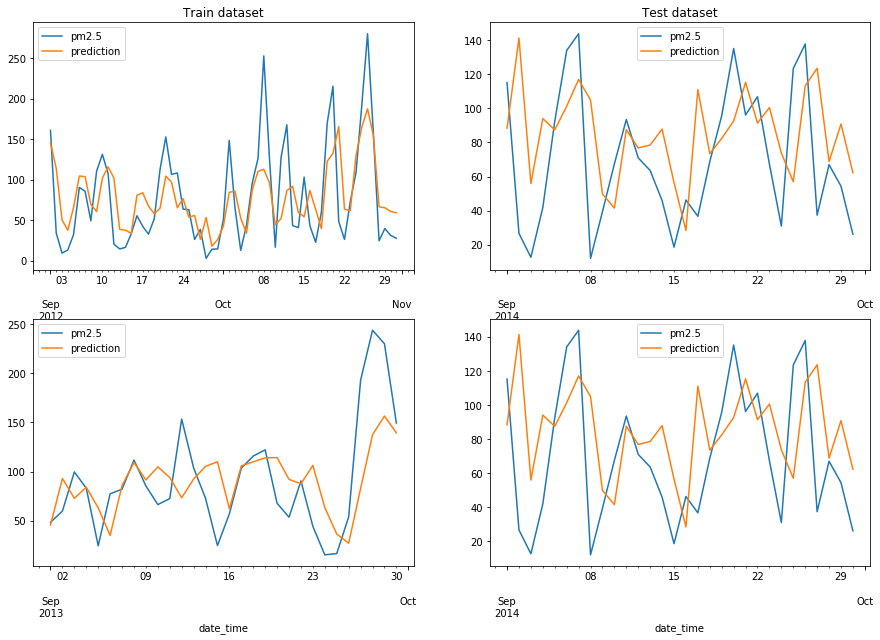

In [126]:
train_score = day_lstm_72.evaluate(x_train, y_train, verbose=0)
print('Train Score: %.2f MSE (%.2f RMSE)' % (train_score, math.sqrt(train_score)))
test_score = day_lstm_72.evaluate(x_test, y_test, verbose=0)
print('Test Score: %.2f MSE (%.2f RMSE)' % (test_score, math.sqrt(test_score)))

model = day_lstm_72
train_predict = pd.DataFrame(model.predict(x_train))
test_predict = pd.DataFrame(model.predict(x_test))
train_predict.columns = ['prediction']
train_predict['date_time'] = y_train.index.values
train_predict.set_index('date_time', inplace = True)
train_plot = pd.concat([y_train, train_predict], axis = 1)
test_predict.columns = ['prediction']
test_predict['date_time'] = y_test.index.values
test_predict.set_index('date_time', inplace = True)
test_plot = pd.concat([y_test, test_predict], axis = 1)
fig, axs = plt.subplots(2, 2, figsize = (15, 10))
train_plot['Sep-2012':'Oct-2012'].plot(ax = axs[0, 0])
test_plot['Sep-2014':'Sep-2014'].plot(ax = axs[0, 1])
train_plot['Sep-2013'].plot(ax = axs[1, 0])
test_plot['Sep-2014'].plot(ax = axs[1, 1])
axs[0, 0].title.set_text('Train dataset')
axs[0, 1].title.set_text('Test dataset')
plt.show()

In [127]:
day_attention_72 = Sequential()
day_attention_72.add(LSTM(24, input_shape = (lookback * 24, 1), return_sequences = True))
day_attention_72.add(Attention())
day_attention_72.add(Dense(1))
day_attention_72.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_7 (LSTM)                (None, 72, 24)            2496      
_________________________________________________________________
attention_4 (Attention)      (None, 24)                96        
_________________________________________________________________
dense_28 (Dense)             (None, 1)                 25        
Total params: 2,617
Trainable params: 2,617
Non-trainable params: 0
_________________________________________________________________


In [137]:
day_attention_72.compile(loss = 'mean_squared_error', optimizer = 'adam')
#the model was trained during 20000 epochs in total
day_attention_72.fit(x_train, y_train, epochs = 10, verbose = 1, batch_size = 128, validation_split = 0.1)

Train on 1249 samples, validate on 139 samples
Epoch 1/10
1249/1249 [==============================] - 6s 5ms/step - loss: 2268.1457 - val_loss: 5378.8878
Epoch 2/10
1249/1249 [==============================] - 2s 1ms/step - loss: 2297.0275 - val_loss: 5479.0721
Epoch 3/10
1249/1249 [==============================] - 2s 1ms/step - loss: 2246.5044 - val_loss: 5358.4343
Epoch 4/10
1249/1249 [==============================] - 2s 1ms/step - loss: 2237.6086 - val_loss: 5390.0605
Epoch 5/10
1249/1249 [==============================] - 2s 1ms/step - loss: 2241.9928 - val_loss: 5427.0791
Epoch 6/10
1249/1249 [==============================] - 2s 1ms/step - loss: 2175.0767 - val_loss: 5616.0298
Epoch 7/10
1249/1249 [==============================] - 2s 1ms/step - loss: 2184.8599 - val_loss: 5618.5334
Epoch 8/10
1249/1249 [==============================] - 2s 1ms/step - loss: 2211.3408 - val_loss: 5524.3822
Epoch 9/10
1249/1249 [==============================] - 2s 1ms/step - loss: 2177.2686 - v

In [140]:
day_attention_72.load_weights("models/history_attention_72")

Train Score: 2473.34 MSE (49.73 RMSE)
Test Score: 4444.06 MSE (66.66 RMSE)


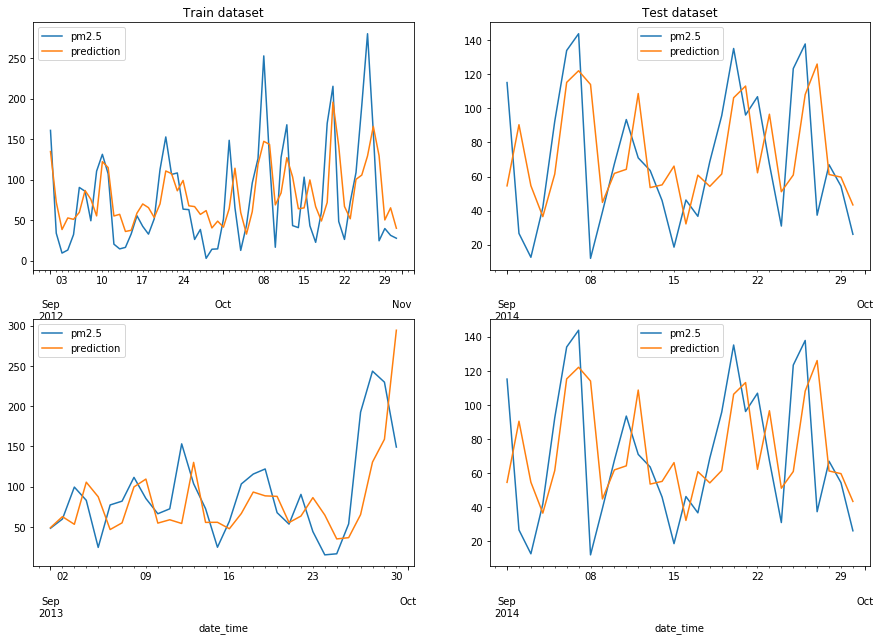

In [141]:
train_score = day_attention_72.evaluate(x_train, y_train, verbose=0)
print('Train Score: %.2f MSE (%.2f RMSE)' % (train_score, math.sqrt(train_score)))
test_score = day_attention_72.evaluate(x_test, y_test, verbose=0)
print('Test Score: %.2f MSE (%.2f RMSE)' % (test_score, math.sqrt(test_score)))

model = day_attention_72
train_predict = pd.DataFrame(model.predict(x_train))
test_predict = pd.DataFrame(model.predict(x_test))
train_predict.columns = ['prediction']
train_predict['date_time'] = y_train.index.values
train_predict.set_index('date_time', inplace = True)
train_plot = pd.concat([y_train, train_predict], axis = 1)
test_predict.columns = ['prediction']
test_predict['date_time'] = y_test.index.values
test_predict.set_index('date_time', inplace = True)
test_plot = pd.concat([y_test, test_predict], axis = 1)
fig, axs = plt.subplots(2, 2, figsize = (15, 10))
train_plot['Sep-2012':'Oct-2012'].plot(ax = axs[0, 0])
test_plot['Sep-2014':'Sep-2014'].plot(ax = axs[0, 1])
train_plot['Sep-2013'].plot(ax = axs[1, 0])
test_plot['Sep-2014'].plot(ax = axs[1, 1])
axs[0, 0].title.set_text('Train dataset')
axs[0, 1].title.set_text('Test dataset')
plt.show()

<p>Both models performed well and outperformed the baseline model with a significant margin.</p>

<p>To summarise, on the first data set when the output variable varied significantly it was easy to bit a baseline model. In fact, fully connected ANNs could outperform the baseline. Next, RNNs were more difficult to train but they were a bit more accurate than fully connected ANNs. LSTM models were more powerful than RNNs and easier to train. For example, I could train an LSTM with 7-day time series input which was not possible with an RNN. Finally, Attent Mechanism further improves LSTM models. The resulting networks were faster to train and produced good results.</p>

<p>In contrast, on China exchange rates dataset the model with Attention Mechanism did not show an improvement over the baseline model. I assume that for such a slowly changing time series more sophisticated models are required. Additionally, it is clear that predicting exchange rates are more difficult task than predicting air pollution.</p>